# NBE-E4260 Genesis and Analysis of Brain Signals 2023
Matias Palva, Vladislav Myrov, Joonas Juvonen, Merlin Dumeur, Joona Repo

## Exercise C, deadline on 15.03.2023 23:59

In this exercise session, we simulate the Kuramoto model using structural brain information, to generate physiologically informed dynamics.

We analyze the simulations using DFA, which you will have to implement, in order to outline the phase transition between synchronization and desynchronization

In [3]:
# First update numpy
# only need to run this once
!pip install -U numpy==1.22.4

# Ignore the error message

     |████████████████████████████████| 16.8 MB 12.8 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spectrum 0.8.1 requires easydev, which is not installed.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.4 which is incompatible.
pystan 3.2.0 requires pysimdjson<4.0,>=3.2, but you have pysimdjson 4.0.2 which is incompatible.
pmdarima 1.8.2 requires numpy~=1.19.0, but you have numpy 1.22.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
httpstan 4.5.0 requires webargs<8.0,>=7.0, but you have webargs 8.1.0 which is incompatible.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm

from Kuramoto import KuramotoFast
print(np.__version__)

1.22.4


## 1. Kuramoto model with connectome

The connectome is the graph that represents the structural coupling between different nodes. It is represented as a $N\times N$ matrix where $N$ is the number of nodes.

After loading the connectome, plot the connectome and the distribution of the weight values. The connectome plot should show the weights even though they follow a very heavy-tailed distribution.

You will need the following:

- `plt.imshow`
- `plt.colorbar`
- `plt.hist`

optional:
- `matplotlib.colors.SymLogNorm`

In [2]:
connectome = np.load("structural_connectome.npy")

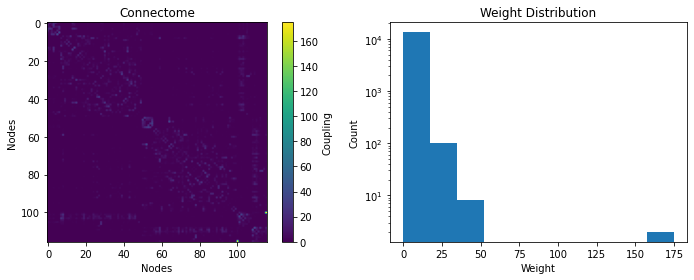

In [3]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

# YOUR CODE HERE
# Plotting the connectome
ax1.imshow(connectome)
ax1.figure.colorbar(ax1.images[0], ax=ax1, label='Coupling')
ax1.set_xlabel('Nodes')
ax1.set_ylabel('Nodes')
ax1.set_title('Connectome')
# Plotting the distribution of the weight values
ax2.hist(connectome.flatten(), log = True)
ax2.set_title('Weight Distribution')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

We now want to simulate the Kuramoto model using this connectome.

## 2. Simulate data with Kuramoto model

Given otherwise fixed parameters, your task is to simulate the model for various values of $L$. The connectome is provided to the model in the `weight_matrix` parameter, after scaling it by a factor of $L$.

The first 2000 samples have the model still affected by the initial conditions, and so need to be discarded.

The time series array from the simulations should be appended to the `simulations` list

You can reuse the code from Exercise set B or the lecture slides to start with, but make sure to use this exercise's parameter values

In [4]:
n_nodes = 116
n_oscillators = 50

k = 10
k_list = [k]*n_nodes
l_values = np.linspace(1, 30, 10)

freq = 10
node_frequencies = [freq]*n_nodes
frequency_spread = 3

sampling_rate = 200
time = 20

use_cuda = False

simulations = []

#YOUR CODE HERE
for L in l_values:
    weight_matrix = connectome * L
    kuramoto = KuramotoFast(n_nodes = n_nodes, n_oscillators = n_oscillators, 
                             sampling_rate = sampling_rate, k_list = k_list,
                             node_frequencies = node_frequencies, frequency_spread = frequency_spread,
                             weight_matrix = weight_matrix, use_cuda = use_cuda)
    simulation = kuramoto.simulate(time = time)
    simulations.append(simulation[:,2000:])
    
simulations = np.array(simulations)

## 3. Compute and visualize order and variability

After succesfully running the above simulations, loop through all the simulations in the lists created above and compute order and variance for all simulations.
Append the results to the `order` and `std` lists, then visualize the results.

Use [matplotlib.axes.Axes.twinx](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html) to plot the order on a different y-scale from the standard deviation

Don't forget to add legends.

In [5]:
order = []
std = []
#YOUR CODE HERE
#Computing order and variability
print(simulations.shape)
for i in range(simulations.shape[0]):
    order.append(np.abs(simulations[i,:,:]).mean(axis=(0,1)))
    std.append(np.abs(simulations[i,:,:]).std(axis=0).mean())
print(np.array(order).shape)
print(np.array(std).shape)

(10, 116, 2001)
(10,)
(10,)


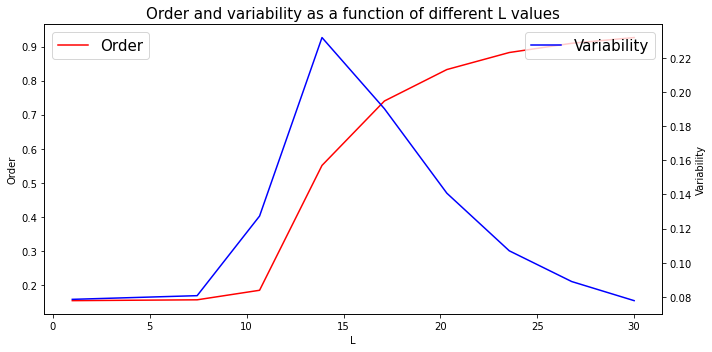

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

# YOUR CODE HERE
#Plotting
ax_twinx = ax.twinx()
ax.plot(l_values, order, '-r')
ax_twinx.plot(l_values, std, '-b')
ax.set_xlabel('L')
ax.set_ylabel('Order')
ax_twinx.set_ylabel('Variability')
ax_twinx.legend(['Variability'], fontsize = 15)
ax.legend(['Order'], fontsize = 15)
plt.title('Order and variability as a function of different L values', fontsize = 15)
plt.tight_layout()
plt.show()

## 4. Selecting subcritical, critical and supercritical regime L values

By inspecting the above plot, identify and pick three $L$ values for which the model is critical, clearly subcritical, and clearly supercritical. Use these $L$ values to compute yet another set of `KuramotoFast` simulations with the otherwise given parameters. In JupyterHub with CPU these simulations take a few minutes. We do this because we need a longer dataset!

As before, remove the first 2000 samples of each simulation before storing the results.

In [7]:
n_nodes = 116
n_oscillators = 50

k = 10
k_list = [k]*n_nodes

freq = 10
node_frequencies = [freq]*n_nodes
frequency_spread = 3

sampling_rate = 200
time = 60

use_cuda = False
simulations2 = []

# YOUR CODE HERE
L = [3, 13, 30] #Based on previous plot choosing subcrit_L=3, crit_L=14, and supercrit_L=30.
for l in L:
    weight_matrix = connectome * l
    kuramoto = KuramotoFast(n_nodes = n_nodes, n_oscillators = n_oscillators, 
                             sampling_rate = sampling_rate, k_list = k_list,
                             node_frequencies = node_frequencies, frequency_spread = frequency_spread,
                             weight_matrix = weight_matrix, use_cuda = use_cuda).simulate(time)
    kuramoto = kuramoto[:, 2000:]
    simulations2.append(kuramoto)
    
simulations2 = np.array(simulations2)

In [8]:
print(simulations2.shape)

(3, 116, 10001)


## 5. Write a function for computing DFA

The use of DFA is to provide a way to estimate the self-similarity of a time series.

Practically, it investigates the **fluctuations** of locally **detrended** segments of the integrated time series.

The fluctuation function $F$ follows a power law if the time series is self-similar:

$$F(n) \propto n^\alpha$$

The exponent $\alpha$ informs on the nature of self-correlations within the time series:

- $\alpha = 0.5 \quad$ **white noise**

- $0.5 < \alpha < 1 \quad$ **correlated noise**

- $\alpha > 1 \quad$ **random walk**

- $\alpha = 1.5 \quad$ **brownian motion**

### Method

To estimate $F$:

1. Integrate the time series to obtain a random walk process $X$;
2. Divide the $X$ into segments of different sizes $n$;
3. On each segment, fit the linear trend $Y$ of the signal;
4. Compute the standard deviation of the detrended signal $X - Y$ for each segment, then average.

Giving the formula for $F$:

$$F(n) = \frac{1}{N_n} \sum_{k=1}^{N_n} \sqrt{\sum_t \left( X_i^n(t) - Y_i^n(t) \right)^2}$$

Where:

- $N_n$ is the number of segments of size $n$
- $X_i^n$ is the ith segment of size $n$ of X
- $Y_i^n$ is the ith segment of size $n$ of Y

The exponent $\alpha$ of the power law is determined by a linear fit in log-log space:
$$\log F(n) = K + \alpha \log n$$

For reference, the introductory publication:

[Peng, C.-K. et al. (1994). Mosaic organization of DNA nucleotides. In <i>PHYSICAL REVIEW E</i>](https://doi.org/10.1103/PhysRevE.49.1685)

### Hints

You may need the following numpy functions:

- [`np.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) for linear regression
- [`np.polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html)
- [`np.cumsum`](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) for integration
- [`plt.loglog`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.loglog.html)
- [`plt.vlines`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.vlines.html)

1. Complete the `compute_Fn` and `compute_F` according to the method above.

In [9]:
def compute_Fn(X, n):
    """
    Computes the fluctuation function of an integrated signal for a given
    segment size n

    Parameters
    ----------
    X: Integrated input signal
    n: segment size

    Returns
    -------
    Fn: F(n) average fluctuation at size n
    """

    # step 2: cut the data in segmnents
    Xn = np.lib.stride_tricks.sliding_window_view(
        X, window_shape=(n))

    # Fn_array stores the fluctuation for each window
    n_segments = Xn.shape[0]
    Fn_array = np.zeros(n_segments)

    t = np.arange(n)
    for i, segment in enumerate(Xn):
        # step 3: fit the linear trend
        # YOUR CODE HERE
        coeff = np.polyfit(t ,segment, 1)
        x = np.polyval(coeff, t)

        # step 4a: compute the standard deviation
        # YOUR CODE HERE
        Fn_array[i] = np.std(segment - x)

    # step 4b: average
    # YOUR CODE HERE
    Fn = np.mean(Fn_array)

    return Fn


def compute_F(X, segment_sizes):
    """
    Computes the fluctuation function F for multiple given segment sizes

    Parameters
    ----------
    X: array shape (n_nodes, n_samples); original simulation
    segment_sizes: list of segment sizes n to for which to compute F

    Returns
    -------
    F: array shape (n_segment_sizes) values of the fluctuation function F for
        window sizes: F<segment_sizes>
    """

    n_nodes = X.shape[0]
    F = np.zeros((n_nodes, segment_sizes.shape[0]))

    # step 1: integrate the signal
    # YOUR CODE HERE
    mean = np.mean(X, axis = 1).reshape(X.shape[0],1)
    X_int = np.cumsum(X - mean, axis = 1)
    
    for node in tqdm(range(n_nodes)):
        for i, n in enumerate(segment_sizes):
            F[node, i] = compute_Fn(X_int[node], n)
    
    # Averaging across nodes
    F = F.mean(axis=0)
    
    return F

2. Compute and plot the fluctuation function $F$ for one simulation, for the given segment sizes.
Given that this is a slow implementation, it is fine to give the time series from only 5 nodes.

The `compute_F` function takes an array that has a shape `(n_nodes, n_samples)`, which is the shape of arrays from the Kuramoto simulation function.

It should be a monotonically increasing function of the segment size $n$.

When plotting, on the x-axis convert the segment sizes to number of oscillations cycles, given as:

$$ N_{\rm cycles} = \frac{n \times f}{f_s}$$

- $n$ segment size
- $f$ oscillatiory frequency
- $f_s$ sampling frequency

Do not forget axes labels and plot title.


In [10]:
segment_sizes = np.geomspace(sampling_rate * 60 / freq, simulations2[0].shape[-1], 20).astype(int)
N_cycles = segment_sizes*freq/sampling_rate
print(simulations2.shape)
X = simulations2[0,0:5,:] # Fill this in
print(X.shape)
F = compute_F(X, segment_sizes)

(3, 116, 10001)
(5, 10001)


  0%|          | 0/5 [00:00<?, ?it/s]

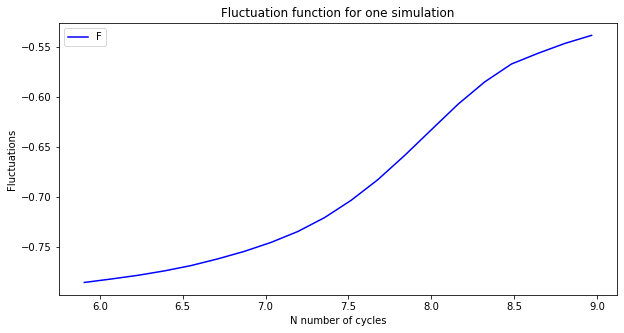

In [12]:
# YOUR CODE HERE
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.log2(N_cycles), np.log2(F), '-b', label = 'F')
ax.set_title('Fluctuation function for one simulation')
ax.set_xlabel('N number of cycles')
ax.set_ylabel('Fluctuations')
ax.legend()
plt.show()

3. Complete the function for estimating the slope coefficient $\alpha$

In [13]:
def compute_DFA(segment_sizes, F, fitting_range):
    """
    Parameters
    ----------
    segment_sizes: list of segment sizes n to for which to compute F
    F: array shape (n_segment_sizes) values of the fluctuation function F for
        window sizes: F<segment_sizes>
    fitting_range: window size range over which to perform the fit for alpha
        e.g. (10, 2000)

    Returns
    -------
    alpha: slope coefficient
    intercept: intercept of the linear fit
    """

    # step 5: compute linear fit
    # fitting range may be different from the segment size range
    idx_size = (segment_sizes > fitting_range[0]) & (segment_sizes < fitting_range[1])

    # YOUR CODE HERE -- use idx_size to select the relevant values for the linear fit
    alpha, intercept = np.polyfit(np.log2(segment_sizes[idx_size]), np.log2(F[idx_size]), 1)

    return alpha, intercept

4. Now compute and plot the DFA fit

Pick the range of segment sizes over which the fluctuation function will be computed.
As we are doing a linear regression, $F$ needs to be approximately linear over that range of segment sizes.

Take the code for the plot above, then add a line indicating the slope fit for $\alpha$. Make the fitting range apparent in the plot as well.

Remember that $\alpha$ is the slope coefficient of $\log F$, not $F$.

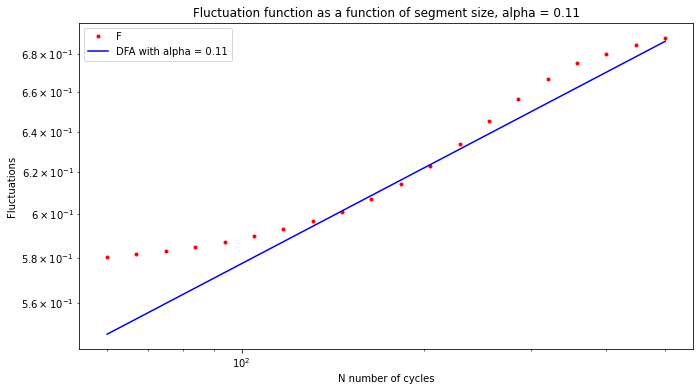

In [14]:
# choose fitting range
fitting_range = segment_sizes[[6,-7]]
alpha, intercept = compute_DFA(segment_sizes, F, fitting_range)

# YOUR CODE HERE
y = intercept + alpha*np.log2(segment_sizes)
fig, ax = plt.subplots(figsize=(11,6))
ax.loglog(N_cycles, F, '.r', label = 'F')
ax.plot(N_cycles, 2**y, '-b', label = f'DFA with alpha = {alpha:.2f}')
ax.set_title(f'Fluctuation function as a function of segment size, alpha = {alpha:.2f}')
ax.set_xlabel('N number of cycles')
ax.set_ylabel('Fluctuations')
ax.legend()
plt.show()

5. Compare the 3 simulations using DFA

Now we are interested in using DFA to compare the long-range temporal correlations in the 3 simulations -- subcritical, critical, supercritical.

Compute, and plot $F$ and $\alpha$ for all simulations in `simulations2`. Use 3 subplots to do so.
Make sure that $\alpha$ is apparent in the plot legend.

As before, it is fine to compute $F$ on only 5 of the nodes from the simulation, as it may already take a while with few time series.

  0%|          | 0/5 [00:00<?, ?it/s]

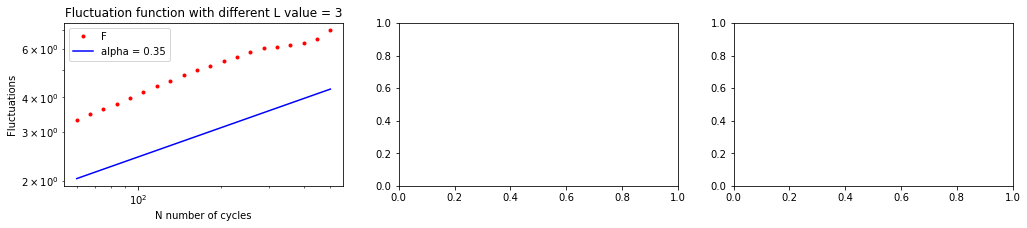

  0%|          | 0/5 [00:00<?, ?it/s]

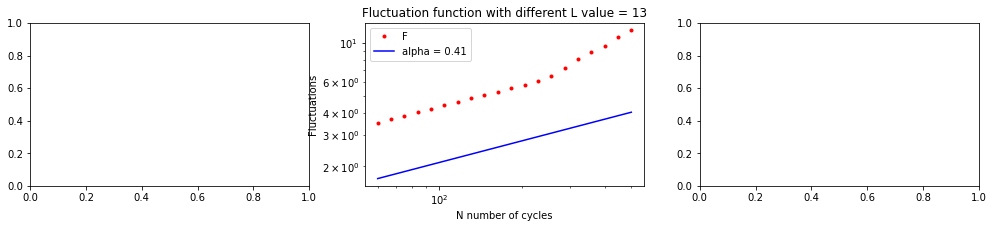

  0%|          | 0/5 [00:00<?, ?it/s]

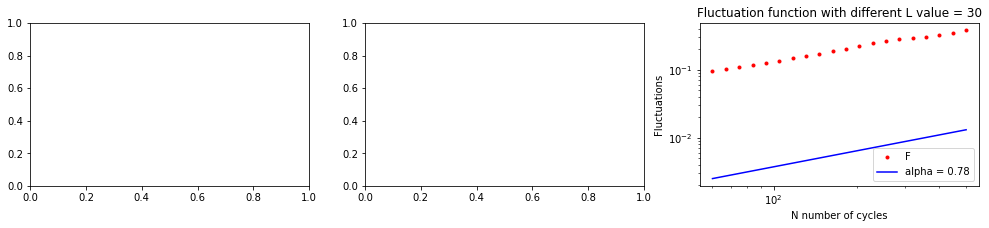

In [19]:
# YOUR CODE HERE
for i, simulations in enumerate(simulations2):
    fig, ax = plt.subplots(1, 3, figsize=(17, 3))
    F = compute_F(abs(simulations[0:5,:]), segment_sizes)
    alpha, intercept = compute_DFA(segment_sizes, F, fitting_range)
    ax[i].loglog(N_cycles, F, '.r', label = 'F')
    ax[i].loglog(N_cycles, np.exp(intercept)*segment_sizes**alpha, '-b', label = f'alpha = {alpha:.2f}')
    ax[i].set_ylabel('Fluctuations')
    ax[i].set_xlabel('N number of cycles')
    ax[i].set_title(f'Fluctuation function with different L value = {L[i]}')
    ax[i].legend()
    plt.show()

### Bonus questions to go further (1 pt if you answer correctly a question)

1. Why is detrending needed in *Detrended* Fluctuation Analysis? You may try to modify the function you wrote. Effects will be most visible with simulations at the critical point.

1. For white noise $\alpha=0.5$. However, you will have found $\alpha$ values lower than 0.5 on the subcritical simulations. Explain what this means, and propose an explanation why the model generates those values far from the critical point. Generating simulations and looking at time series will be helpful.

In [ ]:
# 1. Detrending is needed in DFA because it helps to separate long-term and short-term fluctuations from one another. 
# 2. This can be due to not optimal parameters in model for generating long-term fluctuations.

# NBE-E4260 Quarterly Exam 3

### Glossary (10 points)
Explain these terms accurately. Aim to use only 1 or 2 sentences per point potentially awarded for the reply. 

1. MEG (1 pt)
2. EEG (1 pt)
3. Source modeling (incl. “Forward/Inverse problem”, “Head model”, “Source model”, “Forward/Inverse operator”, and “Forward/Inverse transform”) (4 pts)
4. Source leakage (incl. “Linear mixing”, “Signal mixing”, and “Volume conduction”) (2 pts)
5. Artificial and Spurious observations in correlation measures (2 pts)


### Essay 1 (10 points)
Expected length max. 1 A4 page for the whole essay

Describe the key features, advantages, and challenges in using MEG and EEG for studying local neuronal dynamics and inter-areal relationships. 
What do terms "evoked, induced, stimulus-locked, and non-stimulus-locked (responses)" mean? Explain the event-related research paradigm in cognitive neuroscience and these response types them from phenomenological, neurophysiological, and mathematical perspectives.
How would you (i) implement an inter-areal phase synchronization analysis, (ii) assess its statistical significance, and (iii) mitigate the problems of false positive and negative findings. 


### Essay 2 (10 points)
Expected length max. 1 A4 page for the whole essay

Create a hypothetical MEG/EEG experiment where you address the neurophysiological “network dynamics” correlates of a cognitive construct that interests you. Consider at least: experimental design, behavioral operationalization of the cognitive construct, concurrent MEG/EEG data acquisition, elementary preprocessing, and then the actual data-analysis stages where you define the analysis metrics and how they will be subjected to statistics for hypothesis testing. Feel free to use the project-deck structure in segmenting this essay.